In [1]:
import os

import rasterio
from rasterio.plot import reshape_as_image
import rasterio.mask
from rasterio.features import rasterize

import pandas as pd
import geopandas as gpd
from shapely.geometry import mapping, Point, Polygon
from shapely.ops import unary_union

import numpy as np
import cv2
import matplotlib.pyplot as plt

import glob

%matplotlib inline

In [2]:
DATA_PATH = "data/sentinel_kaggle/"
DEV_PATH = "data/proc_data"

In [3]:
tmp_image_path = "data/sentinel_kaggle/S2A_MSIL1C_20160212T084052_N0201_R064_T36UYA_20160212T084510/S2A_MSIL1C_20160212T084052_N0201_R064_T36UYA_20160212T084510.SAFE/GRANULE/L1C_T36UYA_A003350_20160212T084510/IMG_DATA/T36UYA_20160212T084052_TCI.jp2"
src = rasterio.open(tmp_image_path, "r", driver="JP2OpenJPEG")
raster_img = src.read()
raster_meta = src.meta

In [4]:
raster_img.shape

(3, 10980, 10980)

In [5]:
raster_meta

{'driver': 'JP2OpenJPEG',
 'dtype': 'uint8',
 'nodata': None,
 'width': 10980,
 'height': 10980,
 'count': 3,
 'crs': CRS.from_epsg(32636),
 'transform': Affine(10.0, 0.0, 699960.0,
        0.0, -10.0, 5600040.0)}

In [6]:
raster_img = reshape_as_image(raster_img)

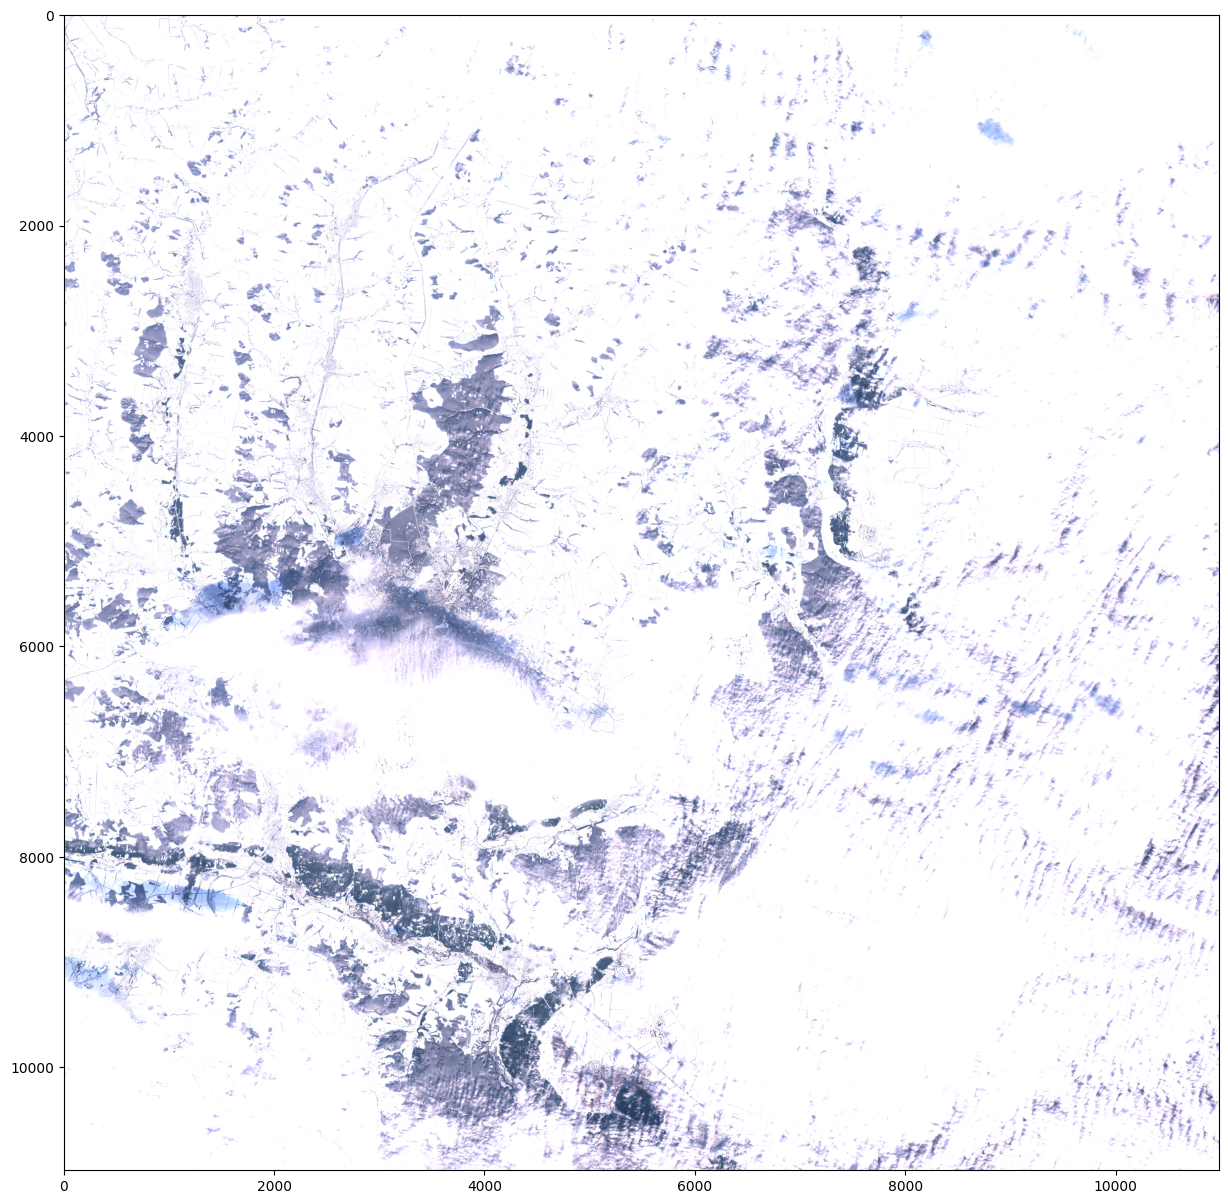

In [7]:
plt.figure(figsize=(15,15))
plt.imshow(raster_img, cmap="grey")
plt.show()

In [4]:
df = gpd.read_file("data/sentinel_kaggle/deforestation_labels.geojson")
df.head()

,img_date,tile,geometry
0,2016-04-09,36UXA,"POLYGON ((35.7913 50.17406, 35.79277 50.17354,..."
1,2016-04-09,36UXA,"POLYGON ((35.77653 50.10271, 35.7781 50.10318,..."
2,2016-04-09,36UXA,"POLYGON ((35.78621 50.01277, 35.78616 50.01369..."
3,2016-04-09,36UXA,"POLYGON ((35.78007 50.00556, 35.78189 50.00557..."
4,2016-04-09,36UXA,"POLYGON ((35.79781 49.99568, 35.79908 49.99582..."


In [5]:
df.crs = {'init':'epsg:4236'}

#transforming polygons to the raster crs
df = df.to_crs({'init' : raster_meta['crs']['init']})

/home/user/Стільниця/python/jpnb_projects/Sentinel-2_image_matching/venv/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [6]:
df.shape

(5696, 3)

In [7]:
df_tmp = df[(df["img_date"] == "2016-02-12") & (df["tile"] == "36UYA")]
df_tmp

,img_date,tile,geometry
4982,2016-02-12,36UYA,"POLYGON ((756758.39 5549895.798, 756825.427 55..."
4983,2016-02-12,36UYA,"POLYGON ((769045.268 5550892.485, 769253.806 5..."
4984,2016-02-12,36UYA,"POLYGON ((773790.66 5551159.139, 773975.179 55..."
4985,2016-02-12,36UYA,"POLYGON ((756758.39 5549895.798, 756825.427 55..."
4986,2016-02-12,36UYA,"POLYGON ((769045.268 5550892.485, 769253.806 5..."
4987,2016-02-12,36UYA,"POLYGON ((773790.66 5551159.139, 773975.179 55..."


In [8]:
def poly_from_utm(polygon, transform):
    # make a polygon from multipolygon
    poly = unary_union(polygon)    
    # transfrom each polygon to image crs, using raster meta
    poly_pts = [~transform * tuple(i[0:2]) for i in np.array(poly.exterior.coords)]
    return Polygon(poly_pts)

# creating binary mask
poly_shp = []
im_size = (src.meta['height'], src.meta['width'])
for num, row in df.iterrows():
    if row['geometry'].geom_type == 'Polygon':
        poly_shp.append(poly_from_utm(row['geometry'], src.meta['transform']))
    """else:
        for p in row['geometry']:
            poly_shp.append(poly_from_utm(p, src.meta['transform']))"""

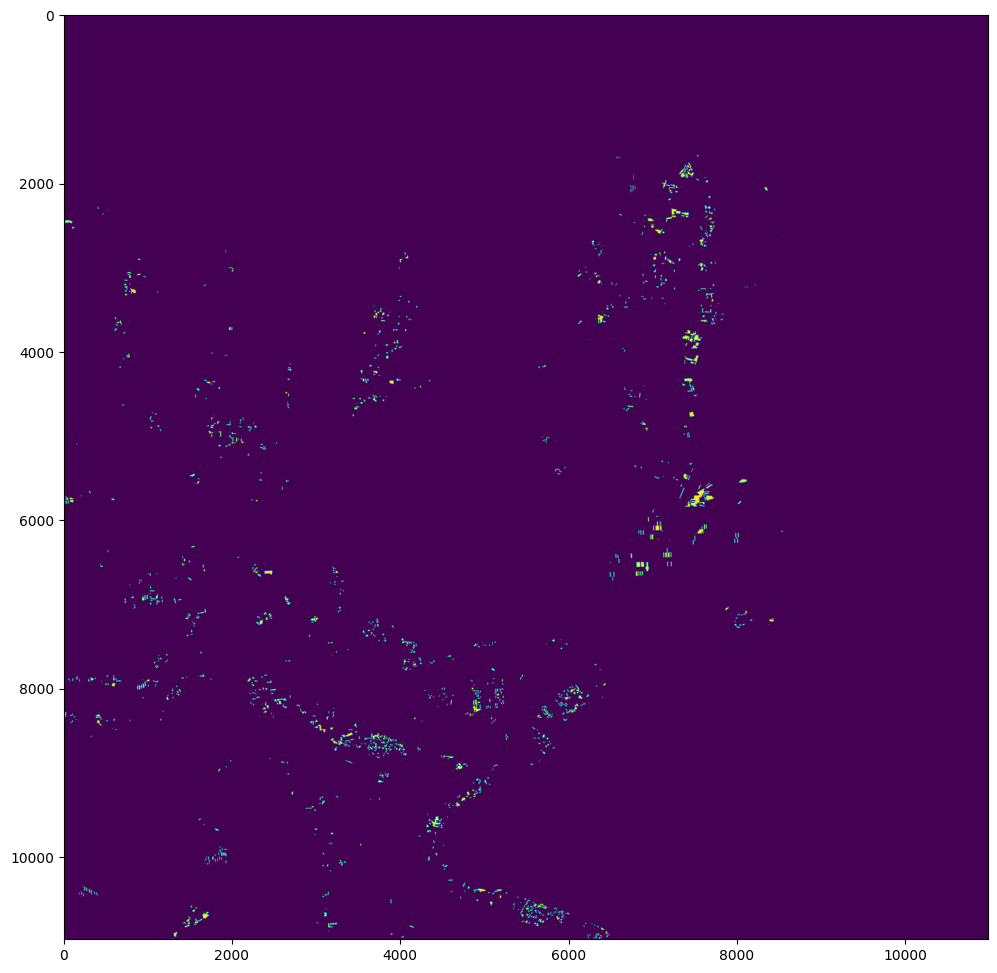

In [9]:
mask = rasterize(shapes=poly_shp, out_shape=im_size)
plt.figure(figsize=(12,12))
plt.imshow(mask)
plt.show()

In [ ]:
def preprocess_and_save_images(base_dataset_path, dev_dataset_path, max_dimension=1024):
    if not os.path.exists(dev_dataset_path):
        os.makedirs(dev_dataset_path)

    for folder in os.listdir(base_dataset_path):
        # Construct the path to the IMG_DATA folder where TCI images are stored
        img_data_path = os.path.join(base_dataset_path, folder, "*.SAFE/GRANULE/*/IMG_DATA/*_TCI.jp2")
        
        # Find the TCI image file
        tci_image_file = glob.glob(img_data_path)
        
        for image_file in tci_image_file:
            
            subdirectory_name = image_file.split('/')[-3]
            dest_subdirectory_path = os.path.join(dev_dataset_path, subdirectory_name)
            
            if not os.path.exists(dest_subdirectory_path):
                os.makedirs(dest_subdirectory_path)
                
            # Preprocess the image
            preprocessed_image = load_and_preprocess_image(image_file, max_dimension)
            
            # Construct the path for saving the preprocessed image
            dest_image_path = os.path.join(dest_subdirectory_path, os.path.basename(image_file).replace('.jp2', '.jpg'))
            # Save the preprocessed image
            cv2.imwrite(dest_image_path, preprocessed_image, [int(cv2.IMWRITE_JPEG_QUALITY), 90])

def load_and_preprocess_image(image_path, max_dimension=1024):
    img = cv2.imread(image_path, 0)  # 0 for grayscale
    height, width = img.shape
    scale = max_dimension / max(height, width)
    resized_img = cv2.resize(img, (int(width * scale), int(height * scale)))
    return resized_img

preprocess_and_save_images(DATA_PATH, DEV_PATH)

In [57]:
def draw_matches_with_recomputed_keypoints(img1_path, img2_path):
    sift = cv2.SIFT_create()
    
    # Load images
    img1 = cv2.imread(img1_path, cv2.IMREAD_GRAYSCALE)
    img2 = cv2.imread(img2_path, cv2.IMREAD_GRAYSCALE)

    # Detect keypoints and compute descriptors
    kp1, des1 = sift.detectAndCompute(img1, None)
    kp2, des2 = sift.detectAndCompute(img2, None)

    # Match descriptors
    bf = cv2.BFMatcher()
    matches = bf.match(des1, des2)
    matches = sorted(matches, key=lambda x: x.distance)

    # Draw first 50 matches
    result = cv2.drawMatches(img1, kp1, img2, kp2, matches[:50], None, flags=2)

    # Display the result
    plt.figure(figsize=(15, 20))
    plt.imshow(result, cmap='gray')
    plt.axis("off")
    plt.show()

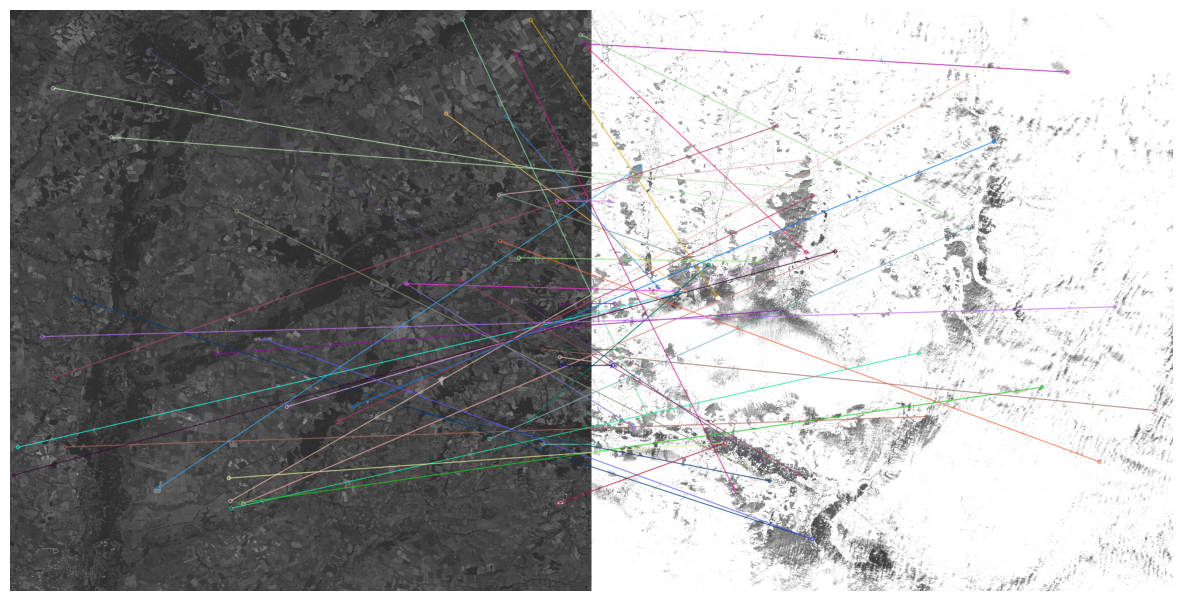

In [58]:
draw_matches_with_recomputed_keypoints("data/proc_data/L1C_T36UXA_A007669_20180825T084235/T36UXA_20180825T083549_TCI.jpg", "data/proc_data/L1C_T36UYA_A003350_20160212T084510/T36UYA_20160212T084052_TCI.jpg")